In [1]:
import pandas as pd
import numpy as np

In [2]:
def load(file):
    """Load the experiment data from a CSV file"""
    
    schema = {
        'First': np.int64(),
        'Last': np.int64(),
        'Parse': np.float64(),
        'Resize': np.float64(),
        'Serialize': np.float64(),
        'Pop': np.float64(),
    }
    
    df = pd.read_csv(file, dtype=schema)
    df.file = file

    return df

In [3]:
import os

def get_meta(path):
    """Returns (threads, num_jsons, repeats)"""
    props = os.path.splitext(os.path.basename(file))[0].split('_')
    return (int(props[1][1:]), int(props[2][1:]), int(props[3][1:]))

def analyze(df):
    """Analyze the experiment data, deriving various metrics."""
    
    df['Total'] = df['Parse'] + df['Resize'] + df['Serialize'] + df['Pop']
    df.threads, df.jsons, df.repeats = get_meta(df.file)
        
    return df

In [4]:
def summarize(df):
    """Summarize the data from all threads into one row."""
    
    row = {'Threads': df.threads,
           'JSONs': df.jsons,
           'Parse': df['Parse'].mean(),
           'Resize': df['Resize'].mean(),
           'Serialize': df['Serialize'].mean(),
           'Pop': df['Pop'].mean(),
           'Total': df['Total'].mean()}
              
    return row;

In [5]:
import glob

csv_files = []
for file in glob.glob("../experiments/data/latency/threads/latency/cpu/*.csv"):
    csv_files.append(file)

records = []
for file in csv_files:
    records.append(summarize(analyze(load(file))))


In [232]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 13
})
    
df = pd.DataFrame.from_records(records).sort_values(by=['Threads', 'JSONs']).set_index(['Threads'])
df.Parse = df.Parse * 1e-9
df.Resize = df.Resize * 1e-9
df.Serialize = df.Serialize * 1e-9
df.Pop = df.Pop * 1e-9
df.Total = df.Total * 1e-9

display(df)

,JSONs,Parse,Resize,Serialize,Pop,Total
Threads,,,,,,
1,1,0.002410,0.000007,0.000123,0.000023,0.002562
1,2,0.002728,0.000007,0.000113,0.000003,0.002852
1,4,0.002814,0.000009,0.000141,0.000026,0.002990
1,8,0.003865,0.000008,0.000113,0.000012,0.003997
1,16,0.003459,0.000009,0.000154,0.000006,0.003627
...,...,...,...,...,...,...
32,32768,0.038828,0.000002,0.000245,0.000079,0.039154
32,65536,0.038140,0.000020,0.000134,0.000094,0.038388
32,131072,0.050346,0.000024,0.000340,0.000063,0.050773


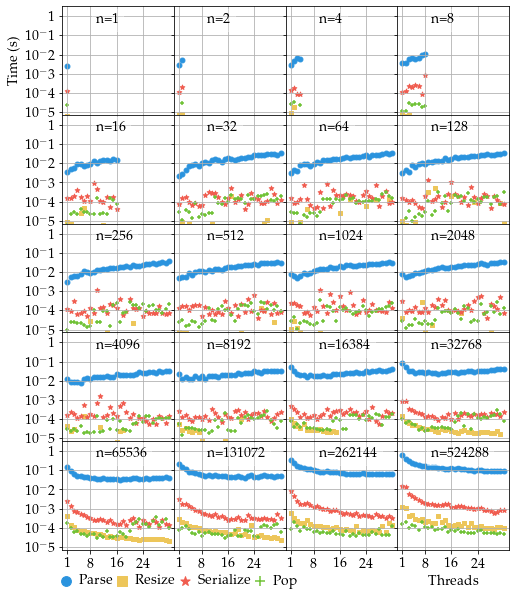

In [270]:
num_jsons = df.JSONs.unique()
num_jsons.sort()

ymax = 5*df.Total.max()
ymin = 5*df.Resize.min()
tmin = df.index.min()
tmax = df.index.max()

cols = 4
rows = int(math.ceil(len(num_jsons)/cols))

xticks = list(range(0,tmax,8))
xticks[0] = 1

yrange = range(round(math.log10(ymin)), 1, 1)
yticks = [10**x for x in yrange]
yticklabels = ['$10^{}$'.format(x) for x in yrange]
yticklabels[-1] = str(1)

colors = ['#2A93DE', '#EDC65A', '#F05C4F', '#70C236', '#AF3FD4']
markers = ['o','s','*','+']
msize = 24

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=[8, 10], sharex='all', sharey='all')
plt.subplots_adjust(wspace=0, hspace=0)
for i, n in enumerate(num_jsons):
    # Determine where to draw
    row = int(i / cols)
    col = i % cols
    ax = axs[row][col]
    
    # Determine which experiment to draw
    subdf = df[df.JSONs == n]
    del subdf['JSONs']
    del subdf['Total']
    
    # Draw points
    #sns.scatterplot(ax=ax, data=subdf, legend=None)
    ppa=ax.scatter(x=subdf.index, y=subdf.Parse, label='Parse', c=colors[0], marker=markers[0], s=msize)
    pre=ax.scatter(x=subdf.index, y=subdf.Resize, label='Resize', c=colors[1], marker=markers[1], s=msize)
    pse=ax.scatter(x=subdf.index, y=subdf.Serialize, label='Serialize', c=colors[2], marker=markers[2], s=msize)
    ppo=ax.scatter(x=subdf.index, y=subdf.Pop, label='Pop', c=colors[3], marker=markers[3], s=msize)
    
    # Set limits and scale
    axs[row][col].set_ylim([ymin, ymax])
    axs[row][col].set_yscale('log')

    ax.set_xlabel(None)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.grid(which='both')
    
    if col == 0 and row == 0:
        ax.set_ylabel('Time (s)')
    else:
        ax.set_ylabel('')
    
    if col == cols-1 and row == rows-1:
        ax.set_xlabel('Threads')
    else:
        ax.set_xlabel('')
    
    ax.annotate('n={}'.format(n), xycoords='axes fraction', xy=(0.3, 0.85), backgroundcolor=(1, 1, 1, 0.33))
    
fig.legend(['Parse', 'Resize', 'Serialize', 'Pop'], 
           ncol=4, 
           bbox_to_anchor=(0.055, -0.39, 0.5, 0.5), 
           frameon=None, shadow=None, framealpha=0.0,
           markerscale=2,
           columnspacing=0.6,
           handlelength=0.24)
    
fig.savefig('jsonsthreadstime.pdf', bbox_inches='tight')


511

511

511

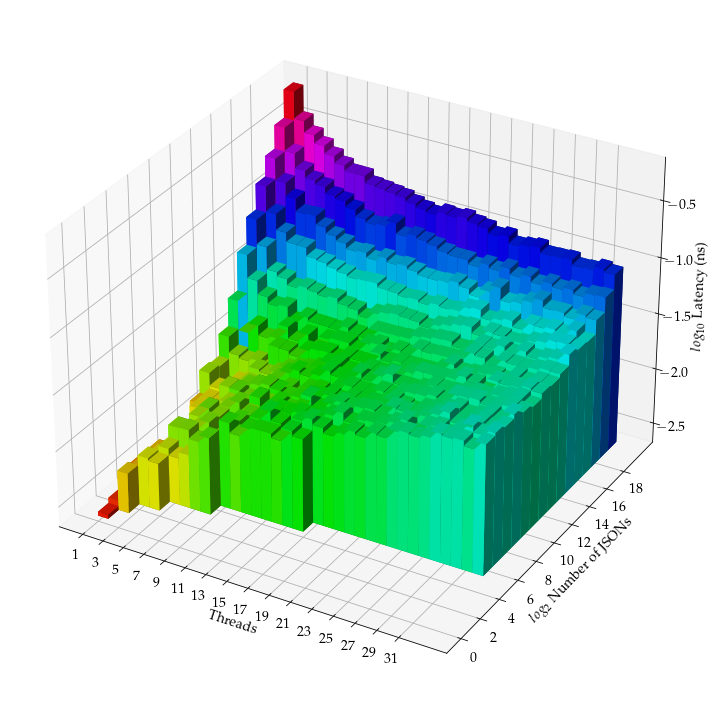

In [279]:
from mpl_toolkits.mplot3d import Axes3D
import cmasher as cmr

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14
})

threads = df.index.unique().to_numpy()
jsons = df.JSONs.unique()

xs = df.index.to_numpy()
ys = np.log2(df.JSONs.to_numpy())
zs = np.log10(df.Total.to_numpy())

bottom = zs.min()
top = zs.max()

display(len(xs))
display(len(ys))
display(len(zs))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
#ax.invert_xaxis()

cmap = plt.get_cmap('hsv')
colors = list(map(lambda x: cmap(round((x - bottom)/(top - bottom) * 255)), zs))

ax.bar3d(x=xs, y=ys, z=bottom, dx=1, dy=1, dz=zs-bottom, color=colors)

#ax.scatter(xs=xs, ys=ys, zs=zs, c=colors)
#for i in range(0, len(xs)):
#    ax.plot(xs=[xs[i], xs[i]], ys=[ys[i], ys[i]], zs=[bottom, zs[i]], c=colors[i], alpha=0.25)

ax.set_zlim(bottom, top)
ax.set_xticks(range(min(xs),max(xs)+1,2))
ax.set_yticks(range(round(min(ys)),round(max(ys))+1,2))

ax.set_ylabel('$log_{2}$ Number of JSONs')
ax.set_xlabel('Threads')
ax.set_zlabel('$log_{10}$ Latency (ns)')

# ax.view_init(35.264, -135)

plt.tight_layout()